# Попрактикуемся с тем, что изучили

Будем практиковаться на датасете:
fetch_california_housing

Ваша задача:
1. Создать Dataset для загрузки данных (используем только числовые данные)
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает число показов на основании числовых данных (вы всегда можете нагенерить дополнительных факторов). Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Учить будем на функцию потерь с кагла (log RMSE) - нужно её реализовать
5. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

Вопросы? в личку @Kinetikm

In [1]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from numpy import mean, std
from torchvision.transforms import Normalize
import torch.nn.functional as F


In [2]:
# Load data
data = fetch_california_housing()
X = data.data
y = data.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [3]:
class HousingDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [4]:
class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.functional.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [5]:
def log_rmse_loss(preds, targets):
    mse_loss = F.mse_loss(preds, targets)
    rmse_loss = torch.sqrt(mse_loss)
    log_rmse_loss = torch.log1p(rmse_loss)
    return log_rmse_loss

In [6]:
# Create datasets and data loaders
train_dataset = HousingDataset(X_train, y_train)
test_dataset = HousingDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create model and optimizer
input_dim = X_train.shape[1]
net = Net(input_dim)

optimizer = optim.Adam(net.parameters(), lr=0.0005)

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 3.81 µs


/var/folders/cy/tzr6g00908v6f2_shl50s7r00000gn/T/ipykernel_34686/537371270.py:2: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = F.mse_loss(preds, targets)
/var/folders/cy/tzr6g00908v6f2_shl50s7r00000gn/T/ipykernel_34686/537371270.py:2: UserWarning: Using a target size (torch.Size([56])) that is different to the input size (torch.Size([56, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = F.mse_loss(preds, targets)
/var/folders/cy/tzr6g00908v6f2_shl50s7r00000gn/T/ipykernel_34686/537371270.py:2: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = F.mse_loss(preds, targ

Adam Epoch 1: train loss 0.89044, test loss 0.77798
Adam Epoch 2: train loss 0.78976, test loss 0.77367
Adam Epoch 3: train loss 0.78430, test loss 0.77516
Adam Epoch 4: train loss 0.78317, test loss 0.76993
Adam Epoch 5: train loss 0.78030, test loss 0.76932
Adam Epoch 6: train loss 0.77942, test loss 0.76843
Adam Epoch 7: train loss 0.77780, test loss 0.77175
Adam Epoch 8: train loss 0.77662, test loss 0.77047
Adam Epoch 9: train loss 0.77636, test loss 0.76841
Adam Epoch 10: train loss 0.77468, test loss 0.76940
Adam Epoch 11: train loss 0.77515, test loss 0.76790
Adam Epoch 12: train loss 0.77410, test loss 0.76799
Adam Epoch 13: train loss 0.77309, test loss 0.76919
Adam Epoch 14: train loss 0.77308, test loss 0.76820
Adam Epoch 15: train loss 0.77284, test loss 0.76781
Adam Epoch 16: train loss 0.77242, test loss 0.76818
Adam Epoch 17: train loss 0.77222, test loss 0.76750
Adam Epoch 18: train loss 0.77153, test loss 0.76809
Adam Epoch 19: train loss 0.77105, test loss 0.76740
Ad

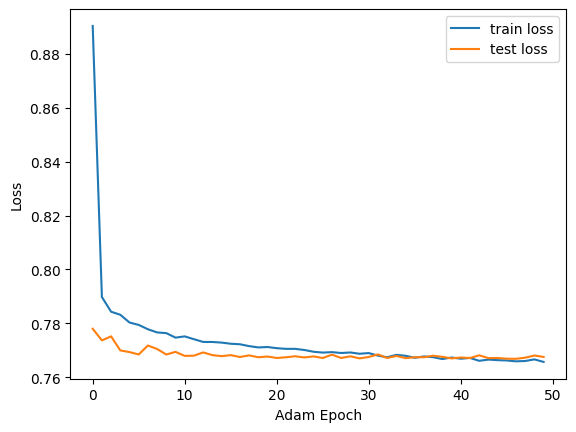

In [7]:
import matplotlib.pyplot as plt

%time
# Training loop
num_epochs = 50
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    net.train()
    epoch_train_losses = []
    for batch in train_loader:
        optimizer.zero_grad()
        inputs, targets = batch
        preds = net(inputs)
        loss = log_rmse_loss(preds, targets)
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())
    train_losses.append(mean(epoch_train_losses))

    net.eval()
    with torch.no_grad():
        epoch_test_losses = []
        for batch in test_loader:
            inputs, targets = batch
            preds = net(inputs)
            loss = log_rmse_loss(preds, targets)
            epoch_test_losses.append(loss.item())
        test_losses.append(mean(epoch_test_losses))

    print(f"Adam Epoch {epoch+1}: train loss {train_losses[-1]:.5f}, test loss {test_losses[-1]:.5f}")

# Plot losses
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.xlabel("Adam Epoch")
plt.ylabel("Loss")
plt.show()

In [8]:
# Create datasets and data loaders
train_dataset = HousingDataset(X_train, y_train)
test_dataset = HousingDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create model and optimizer
input_dim = X_train.shape[1]
net = Net(input_dim)

# adam_optim = optim.Adam(net.parameters(), lr=learning_rate)
# rmsprop_optim = optim.RMSprop(net.parameters(), lr=learning_rate)
# sgd_optim = optim.SGD(net.parameters(), lr=learning_rate)

optimizer = optim.RMSprop(net.parameters(), lr=0.0005)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 4.05 µs


/var/folders/cy/tzr6g00908v6f2_shl50s7r00000gn/T/ipykernel_34686/537371270.py:2: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = F.mse_loss(preds, targets)
/var/folders/cy/tzr6g00908v6f2_shl50s7r00000gn/T/ipykernel_34686/537371270.py:2: UserWarning: Using a target size (torch.Size([56])) that is different to the input size (torch.Size([56, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = F.mse_loss(preds, targets)
/var/folders/cy/tzr6g00908v6f2_shl50s7r00000gn/T/ipykernel_34686/537371270.py:2: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = F.mse_loss(preds, targ

RMSProp Epoch 1: train loss 0.83031, test loss 0.77630
RMSProp Epoch 2: train loss 0.78602, test loss 0.77127
RMSProp Epoch 3: train loss 0.78113, test loss 0.77090
RMSProp Epoch 4: train loss 0.77910, test loss 0.76860
RMSProp Epoch 5: train loss 0.77759, test loss 0.76965
RMSProp Epoch 6: train loss 0.77592, test loss 0.77024
RMSProp Epoch 7: train loss 0.77454, test loss 0.76871
RMSProp Epoch 8: train loss 0.77383, test loss 0.76954
RMSProp Epoch 9: train loss 0.77237, test loss 0.76804
RMSProp Epoch 10: train loss 0.77212, test loss 0.76913
RMSProp Epoch 11: train loss 0.77204, test loss 0.76848
RMSProp Epoch 12: train loss 0.77045, test loss 0.76842
RMSProp Epoch 13: train loss 0.77075, test loss 0.76826
RMSProp Epoch 14: train loss 0.77000, test loss 0.76801
RMSProp Epoch 15: train loss 0.76988, test loss 0.76774
RMSProp Epoch 16: train loss 0.76973, test loss 0.76765
RMSProp Epoch 17: train loss 0.76902, test loss 0.76831
RMSProp Epoch 18: train loss 0.76917, test loss 0.76747
R

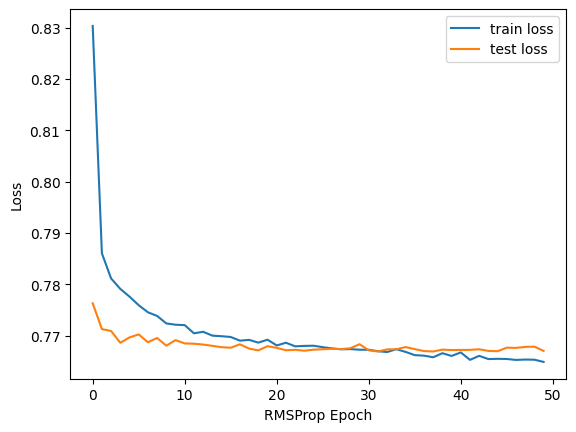

In [9]:
import matplotlib.pyplot as plt

%time
# Training loop
num_epochs = 50
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    net.train()
    epoch_train_losses = []
    for batch in train_loader:
        optimizer.zero_grad()
        inputs, targets = batch
        preds = net(inputs)
        loss = log_rmse_loss(preds, targets)
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())
    train_losses.append(mean(epoch_train_losses))

    net.eval()
    with torch.no_grad():
        epoch_test_losses = []
        for batch in test_loader:
            inputs, targets = batch
            preds = net(inputs)
            loss = log_rmse_loss(preds, targets)
            epoch_test_losses.append(loss.item())
        test_losses.append(mean(epoch_test_losses))

    print(f"RMSProp Epoch {epoch+1}: train loss {train_losses[-1]:.5f}, test loss {test_losses[-1]:.5f}")

# Plot losses
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.xlabel("RMSProp Epoch")
plt.ylabel("Loss")
plt.show()

In [12]:
# Create datasets and data loaders
train_dataset = HousingDataset(X_train, y_train)
test_dataset = HousingDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Create model and optimizer
input_dim = X_train.shape[1]
net = Net(input_dim)

optimizer = optim.SGD(net.parameters(), lr=0.0005)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 3.1 µs


/var/folders/cy/tzr6g00908v6f2_shl50s7r00000gn/T/ipykernel_34686/537371270.py:2: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = F.mse_loss(preds, targets)
/var/folders/cy/tzr6g00908v6f2_shl50s7r00000gn/T/ipykernel_34686/537371270.py:2: UserWarning: Using a target size (torch.Size([56])) that is different to the input size (torch.Size([56, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = F.mse_loss(preds, targets)
/var/folders/cy/tzr6g00908v6f2_shl50s7r00000gn/T/ipykernel_34686/537371270.py:2: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse_loss = F.mse_loss(preds, targ

SGD Epoch 1: train loss 1.25377, test loss 1.22970
SGD Epoch 2: train loss 1.20879, test loss 1.19600
SGD Epoch 3: train loss 1.16316, test loss 1.15538
SGD Epoch 4: train loss 1.11849, test loss 1.13582
SGD Epoch 5: train loss 1.07400, test loss 1.08898
SGD Epoch 6: train loss 1.03204, test loss 1.03744
SGD Epoch 7: train loss 0.99080, test loss 1.00422
SGD Epoch 8: train loss 0.95595, test loss 0.98691
SGD Epoch 9: train loss 0.92342, test loss 0.96214
SGD Epoch 10: train loss 0.89995, test loss 0.91992
SGD Epoch 11: train loss 0.87984, test loss 0.89242
SGD Epoch 12: train loss 0.86336, test loss 0.86678
SGD Epoch 13: train loss 0.85015, test loss 0.85949
SGD Epoch 14: train loss 0.83966, test loss 0.84097
SGD Epoch 15: train loss 0.83392, test loss 0.82938
SGD Epoch 16: train loss 0.82665, test loss 0.82442
SGD Epoch 17: train loss 0.82354, test loss 0.81635
SGD Epoch 18: train loss 0.81949, test loss 0.81817
SGD Epoch 19: train loss 0.81527, test loss 0.81317
SGD Epoch 20: train l

SGD Epoch 158: train loss 0.77800, test loss 0.77459
SGD Epoch 159: train loss 0.77811, test loss 0.77279
SGD Epoch 160: train loss 0.77780, test loss 0.77823
SGD Epoch 161: train loss 0.77661, test loss 0.77370
SGD Epoch 162: train loss 0.77787, test loss 0.77289
SGD Epoch 163: train loss 0.77754, test loss 0.77847
SGD Epoch 164: train loss 0.77618, test loss 0.78613
SGD Epoch 165: train loss 0.77716, test loss 0.77672
SGD Epoch 166: train loss 0.77726, test loss 0.77641
SGD Epoch 167: train loss 0.77763, test loss 0.77369
SGD Epoch 168: train loss 0.77717, test loss 0.77438
SGD Epoch 169: train loss 0.77763, test loss 0.77442
SGD Epoch 170: train loss 0.77713, test loss 0.77420
SGD Epoch 171: train loss 0.77663, test loss 0.77359
SGD Epoch 172: train loss 0.77749, test loss 0.77413
SGD Epoch 173: train loss 0.77680, test loss 0.77669
SGD Epoch 174: train loss 0.77655, test loss 0.77488
SGD Epoch 175: train loss 0.77686, test loss 0.77558
SGD Epoch 176: train loss 0.77714, test loss 0

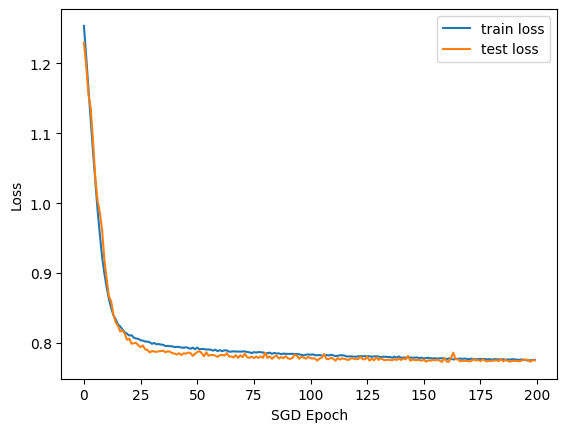

In [13]:
import matplotlib.pyplot as plt

%time
# Training loop
num_epochs = 200
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    net.train()
    epoch_train_losses = []
    for batch in train_loader:
        optimizer.zero_grad()
        inputs, targets = batch
        preds = net(inputs)
        loss = log_rmse_loss(preds, targets)
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())
    train_losses.append(mean(epoch_train_losses))

    net.eval()
    with torch.no_grad():
        epoch_test_losses = []
        for batch in test_loader:
            inputs, targets = batch
            preds = net(inputs)
            loss = log_rmse_loss(preds, targets)
            epoch_test_losses.append(loss.item())
        test_losses.append(mean(epoch_test_losses))

    print(f"SGD Epoch {epoch+1}: train loss {train_losses[-1]:.5f}, test loss {test_losses[-1]:.5f}")

# Plot losses
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.xlabel("SGD Epoch")
plt.ylabel("Loss")
plt.show()

Если сравнивать по потерям, то Adam показал себя лучше на тестовых данных, потому что имеет меньшую потерю на тестовых данных на каждой из 50 эпох.

